# Hyperparameter Tuning of Random Forest Model with preprocessed data

- This notebooks performs a search on some of the random forest's hyperparameters in order to find the optimal model.

- The hyperparameter search is done with Optuna, using a TPE sampler. 

In [16]:
from src.hyperparam_model_tuning import tune_hyperparams, cv_train_best_model
from src.utils.transformers import RobustScaling, OutlierFlagger

import pickle
import optuna
import pandas as pd
import numpy as np
import shap
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, precision_score, average_precision_score, recall_score
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

In [2]:
# Read the data
df = pd.read_csv('data/pulsar_data.csv')

In [3]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='target'), df['target'], test_size=0.2, random_state=42)

In [4]:
# Creates the transformer objects and the pipeline
outlier_flagger_ip = OutlierFlagger(
    outlier_col_name='ip_outlier',
    columns=df.columns[:4],
    random_state=42
)

outlier_flagger_dm = OutlierFlagger(
    outlier_col_name='dm_outlier',
    columns=df.columns[4:8],
    random_state=42
)

robust_scaler = RobustScaling(
    columns=df.columns[:8]
)

model_pipe = Pipeline([
    ('outlier_flagger_ip', outlier_flagger_ip),
    ('outlier_flagger_dm', outlier_flagger_dm),
    ('robust_scaling', robust_scaler),
    ('rf', RandomForestClassifier(random_state=42, class_weight='balanced'))
    ])

In [5]:
# Create the parameter grid for the random forest model
n_estimators = optuna.distributions.IntDistribution(low=100, high=500, step=200) # 3 values
min_samples_leaf = optuna.distributions.IntDistribution(low=1, high=51, step=10) # 6 values
ccp_alpha = optuna.distributions.FloatDistribution(low=0, high=0.01, step=0.0025) # 5 values
max_features = optuna.distributions.IntDistribution(low=3, high=8, step=1) # 6 values

param_grid = { 
    'rf__n_estimators': n_estimators,
    'rf__min_samples_leaf': min_samples_leaf,
    'rf__ccp_alpha': ccp_alpha,
    'rf__max_features': max_features   
}

- The chosen hyperparameters to be tuned in the random forest models are the above. These were chosen as they control the most important aspects in a random forest model.

- The range of values were chosen considering the computational resources available to run the experiments. 

---
## First Tuning - Maximizing Average Precision

- Maximizing average precision through hyperparameter optimization helps in fine-tuning a machine learning model for binary classification tasks, especially when dealing with imbalanced datasets. It ensures that the model is better at distinguishing between positive and negative cases, leading to more accurate and reliable predictions.

- Average precision takes into account both precision and recall, making it a suitable metric for tasks where the balance between false positives and false negatives is crucial

In [6]:
# Tune the hyperparameters
optuna_search_obj_auprc = tune_hyperparams(
    model=model_pipe,
    X_train=X_train,
    y_train=y_train,
    param_grid=param_grid,
    scoring_metric='average_precision',
    cv=3,
    n_trials=200,
    random_state=42,
    n_jobs=-1,
    optuna_obj_filename='optuna_search_obj_auprc.pkl',
    trials_scores_filename='trials_scores_auprc.csv',
)

This hyperparameter search has already been conducted!

Loading the optuna search object...



Returning the search object...



In [8]:
# train the best model
best_model, cv_scores = cv_train_best_model(
    optuna_search_obj=optuna_search_obj_auprc,
    model=model_pipe,
    X_train=X_train,
    y_train=y_train,
    model_file_name='rf_feat_preproc_tuned_auprc.pkl',
    cv_scores_file_name='rf_feat_preproc_tuned_auprc_cv_scores.csv',
    kfolds=3
)


This model has already been trained and saved!

Loading the model and the CV scores...

Returning the model and the CV scores...



In [47]:
best_model.get_params()['rf'].get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 3,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 11,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 500,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [9]:
cv_scores_grouped = cv_scores.groupby('threshold').mean()
cv_scores_grouped

,fit_time,score_time,test_F1-score,test_Accuracy,test_Precision,test_Recall,test_AUC,test_Average Precision
threshold,,,,,,,,
0.10,53.068218,0.900495,0.569207,0.867230,0.406009,0.952195,0.976912,0.927459
0.15,52.139969,0.848553,0.678763,0.918145,0.531436,0.939299,0.976912,0.927459
0.20,51.370821,0.945215,0.746376,0.941821,0.623754,0.929442,0.976912,0.927459
0.25,52.643600,0.803225,0.792335,0.955371,0.693690,0.924130,0.976912,0.927459
0.30,51.311953,0.722191,0.818190,0.962495,0.739005,0.916542,0.976912,0.927459
0.35,50.067894,0.718061,0.831144,0.965917,0.764003,0.911229,0.976912,0.927459
0.40,51.181744,0.790636,0.843032,0.968920,0.787743,0.906680,0.976912,0.927459
0.45,51.295546,0.743877,0.852633,0.971295,0.808288,0.902128,0.976912,0.927459
0.50,44.165510,0.707354,0.860806,0.973320,0.828231,0.896059,0.976912,0.927459


In [10]:
# Calculate the predicted probabilities and the predicted classes for the optimal threshold
opt_threshold = cv_scores_grouped['test_F1-score'].idxmax()
y_pred_scores = best_model.predict_proba(X_test)[:, 1]
y_pred = (y_pred_scores > opt_threshold).astype(int)

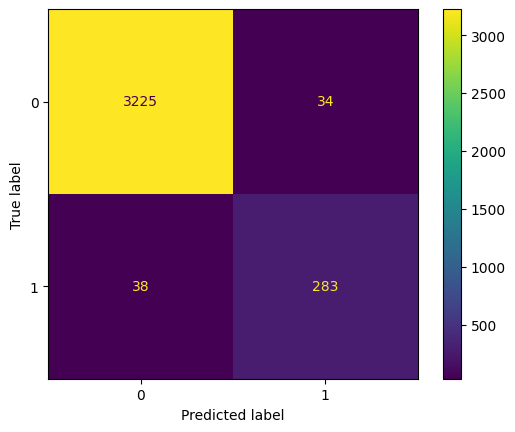

In [11]:
# Plot the confusion matrix with the optimal threshold value for the F1 score (0.45)
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
disp.plot()

In [12]:
# Prints the metrics for the test set
print(f'F1-score: {round(f1_score(y_test, y_pred), 4)}')
print(f'Accuracy: {round(accuracy_score(y_test, y_pred), 4)}')
print(f'Precision: {round(precision_score(y_test, y_pred), 4)}')
print(f'Recall: {round(recall_score(y_test, y_pred), 4)}')
print(f'AUC: {round(roc_auc_score(y_test, y_pred_scores), 4)}')
print(f'Average Precision: {round(average_precision_score(y_test, y_pred_scores), 4)}')

F1-score: 0.8871
Accuracy: 0.9799
Precision: 0.8927
Recall: 0.8816
AUC: 0.9755
Average Precision: 0.929


In [13]:
# Calculate the SHAP values
shap.initjs()
pipe_feats = Pipeline(best_model.steps[:-1])
X_transformed = pipe_feats.transform(df.drop(columns='target'))

explainer = shap.TreeExplainer(best_model.named_steps['rf'])
shap_values = explainer.shap_values(X_transformed)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


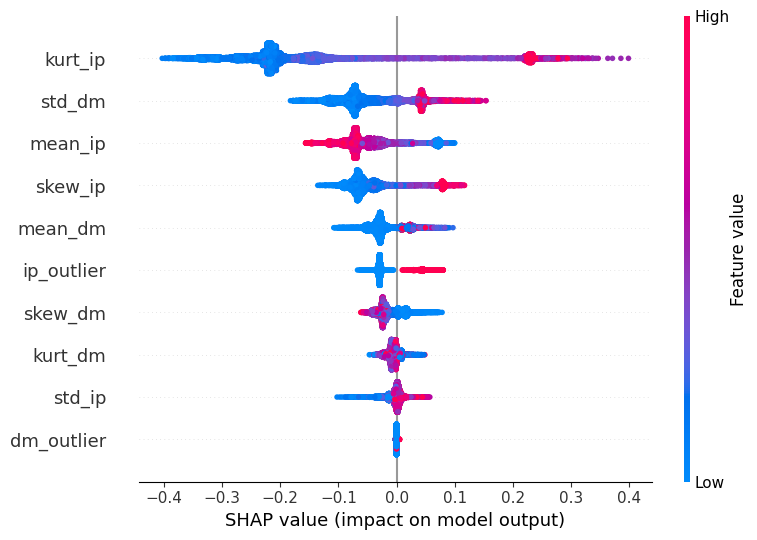

In [14]:
shap.summary_plot(shap_values[1], X_transformed)

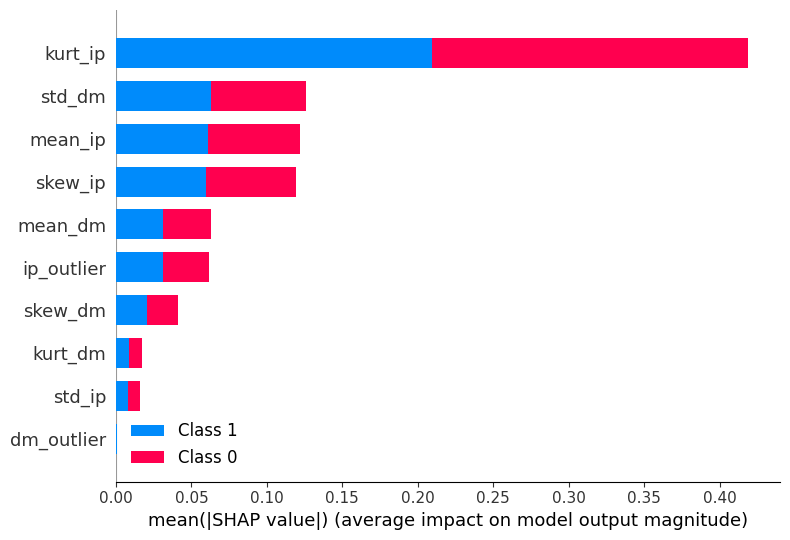

In [15]:
shap.summary_plot(shap_values, X_transformed)

- Similar results can be found in terms of ranking of feature importance when comparing to the baseline model, the main difference is in the shape and magnitude of these importances. Since for this model the features were rescaled with a robust scaler, all features have a similar magnitude. That, combined with the fact that the imbalance is being countered by weighting observations of the minoritary class, the SHAP values are more centered towards zero, with the features having a similar positive and negative impact on the predicted probabilities. This happens because the model's probabilities are biased, which causes the model to have more balanced probabilities.

- Nontheless, the top 4 most important features are still the same as in the baseline, with some small changes in the order of top 2, 3 and 4, but the most important feature remaining the kurtosis in the ip by far.

---
## Second Tuning - Maximizing AUC

- AUC specifically emphasizes a model's discrimination ability, which is essential in scenarios where the class distribution is imbalanced or when the cost of false positives and false negatives varies. By optimizing hyperparameters for AUC, one ensures that the model can effectively separate positive and negative instances.

- AUC is a similar metric to the Average precision, hence a round where it is maximized can generate an excellente discriminative model.

In [17]:
# Tune the hyperparameters
optuna_search_obj_auc = tune_hyperparams(
    model=model_pipe,
    X_train=X_train,
    y_train=y_train,
    param_grid=param_grid,
    scoring_metric='roc_auc',
    cv=3,
    n_trials=200,
    random_state=42,
    n_jobs=-1,
    optuna_obj_filename='optuna_search_obj_auc.pkl',
    trials_scores_filename='trials_scores_auc.csv',
)

This hyperparameter search has already been conducted!

Loading the optuna search object...

Returning the search object...



In [19]:
# train the best model
best_model_auc, cv_scores_auc = cv_train_best_model(
    optuna_search_obj=optuna_search_obj_auc,
    model=model_pipe,
    X_train=X_train,
    y_train=y_train,
    model_file_name='rf_feat_preproc_tuned_auc.pkl',
    cv_scores_file_name='rf_feat_preproc_tuned_auc_cv_scores.csv',
    kfolds=3
)

This model has already been trained and saved!

Loading the model and the CV scores...

Returning the model and the CV scores...



In [46]:
best_model_auc.get_params()['rf'].get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 4,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 41,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 500,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [20]:
cv_scores_grouped_auc = cv_scores_auc.groupby('threshold').mean()
cv_scores_grouped_auc

,fit_time,score_time,test_F1-score,test_Accuracy,test_Precision,test_Recall,test_AUC,test_Average Precision
threshold,,,,,,,,
0.10,48.382344,0.614860,0.463452,0.794245,0.304977,0.965096,0.977139,0.925156
0.15,45.322294,0.545939,0.563962,0.864576,0.401002,0.950680,0.977139,0.925156
0.20,45.069942,0.601241,0.642121,0.902919,0.486312,0.945367,0.977139,0.925156
0.25,44.902958,0.510860,0.708039,0.929040,0.570733,0.933233,0.977139,0.925156
0.30,44.655831,0.615876,0.753011,0.943916,0.634401,0.927166,0.977139,0.925156
0.35,44.373485,0.606973,0.782092,0.952577,0.678108,0.924134,0.977139,0.925156
0.40,43.076235,0.635633,0.801588,0.958165,0.711444,0.918064,0.977139,0.925156
0.45,44.314972,0.640962,0.816494,0.962146,0.737138,0.915029,0.977139,0.925156
0.50,44.958997,0.611420,0.831876,0.966127,0.765788,0.910475,0.977139,0.925156


In [21]:
# Calculate the predicted probabilities and the predicted classes for the optimal threshold
opt_threshold = cv_scores_grouped_auc['test_F1-score'].idxmax()
y_pred_scores = best_model_auc.predict_proba(X_test)[:, 1]
y_pred = (y_pred_scores > opt_threshold).astype(int)

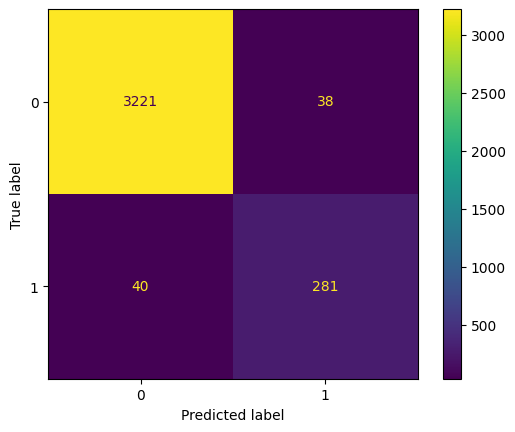

In [22]:
# Plot the confusion matrix with the optimal threshold value for the F1 score (0.45)
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
disp.plot()

In [23]:
# Prints the metrics for the test set
print(f'F1-score: {round(f1_score(y_test, y_pred), 4)}')
print(f'Accuracy: {round(accuracy_score(y_test, y_pred), 4)}')
print(f'Precision: {round(precision_score(y_test, y_pred), 4)}')
print(f'Recall: {round(recall_score(y_test, y_pred), 4)}')
print(f'AUC: {round(roc_auc_score(y_test, y_pred_scores), 4)}')
print(f'Average Precision: {round(average_precision_score(y_test, y_pred_scores), 4)}')

F1-score: 0.8781
Accuracy: 0.9782
Precision: 0.8809
Recall: 0.8754
AUC: 0.9751
Average Precision: 0.9256


In [61]:
# Calculate the SHAP values
explainer_auc = shap.TreeExplainer(best_model_auc.named_steps['rf'])
shap_values_auc = explainer_auc.shap_values(X_transformed)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


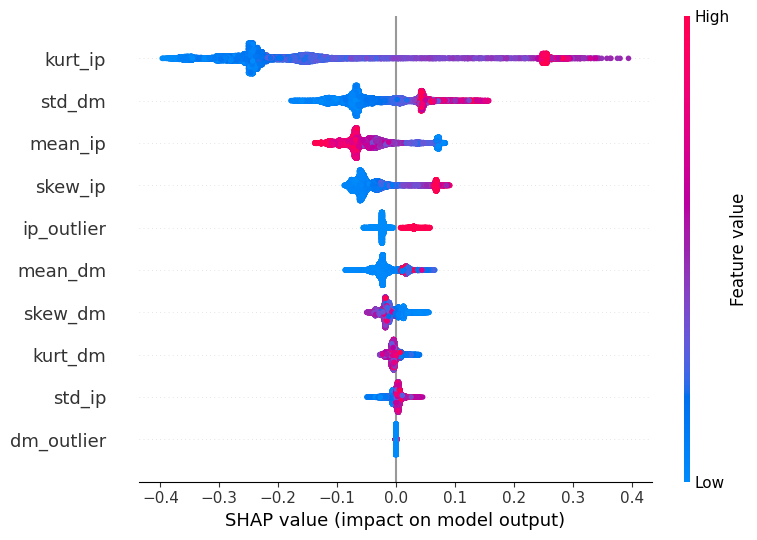

In [62]:
shap.summary_plot(shap_values_auc[1], X_transformed)

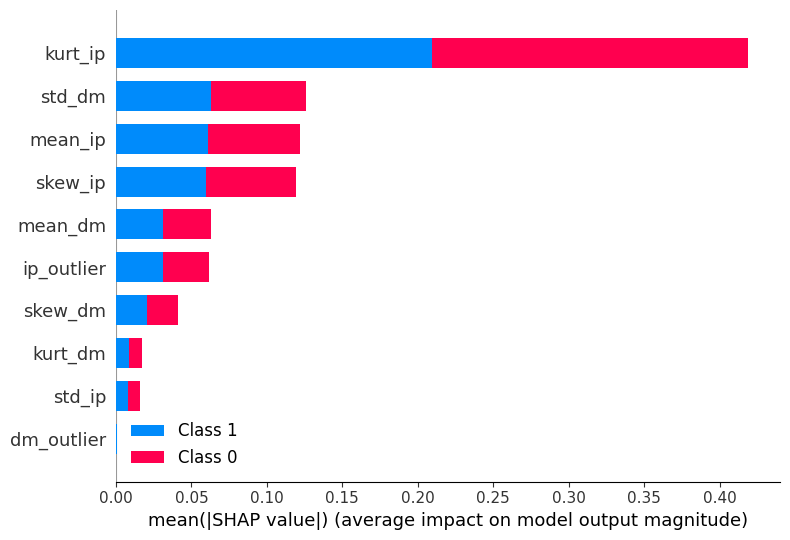

In [ ]:
shap.summary_plot(shap_values_auc, X_transformed)

---
## Third Tuning - Maximizing Average Precision without the feature preprocessing pipeline

- On this last test, the feature preprocessing pipeline was removed, and the option to balance the weigths was introduced as a hyperparameter option, in order to test the capacity of improvement of the random forest model with the raw data.

In [24]:
sole_model = RandomForestClassifier(random_state=42)

In [25]:
# Create the parameter grid for the random forest model
n_estimators = optuna.distributions.IntDistribution(low=100, high=500, step=100) # 5 values
min_samples_leaf = optuna.distributions.IntDistribution(low=1, high=51, step=10) # 6 values
ccp_alpha = optuna.distributions.FloatDistribution(low=0, high=0.01, step=0.0025) # 5 values
max_features = optuna.distributions.IntDistribution(low=3, high=8, step=1) # 6 values
class_weight = optuna.distributions.CategoricalDistribution(choices=['balanced', None]) # 2 values

param_grid_raw = { 
    'n_estimators': n_estimators,
    'min_samples_leaf': min_samples_leaf,
    'ccp_alpha': ccp_alpha,
    'max_features': max_features,
    'class_weight': class_weight   
}

In [26]:
# Tune the hyperparameters
optuna_search_obj_raw = tune_hyperparams(
    model=sole_model,
    X_train=X_train,
    y_train=y_train,
    param_grid=param_grid_raw,
    scoring_metric='average_precision',
    cv=3,
    n_trials=200,
    random_state=42,
    n_jobs=-1,
    optuna_obj_filename='optuna_search_obj_baseline.pkl',
    trials_scores_filename='trials_scores_baseline.csv',
)

This hyperparameter search has already been conducted!

Loading the optuna search object...

Returning the search object...



In [28]:
# train the best model
best_model_raw, cv_scores_raw = cv_train_best_model(
    optuna_search_obj=optuna_search_obj_raw,
    model=sole_model,
    X_train=X_train,
    y_train=y_train,
    model_file_name='rf_no_preproc_tuned.pkl',
    cv_scores_file_name='rf_no_preproc_tuned_cv_scores.csv',
    kfolds=3
)

This model has already been trained and saved!

Loading the model and the CV scores...

Returning the model and the CV scores...



In [45]:
best_model_raw.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 4,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 11,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 500,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [29]:
cv_scores_grouped_raw = cv_scores_raw.groupby('threshold').mean()
cv_scores_grouped_raw

,fit_time,score_time,test_F1-score,test_Accuracy,test_Precision,test_Recall,test_AUC,test_Average Precision
threshold,,,,,,,,
0.10,78.160222,0.600983,0.819964,0.962914,0.741432,0.917302,0.976631,0.927661
0.15,76.779482,0.565250,0.849733,0.970457,0.798935,0.907438,0.976631,0.927661
0.20,82.771178,0.553805,0.860777,0.973390,0.830876,0.893021,0.976631,0.927661
0.25,79.655142,0.660865,0.867882,0.975276,0.854677,0.881639,0.976631,0.927661
0.30,75.550653,0.571054,0.874376,0.976813,0.872510,0.876325,0.976631,0.927661
0.35,75.181238,0.556243,0.881449,0.978489,0.894585,0.868736,0.976631,0.927661
0.40,79.384705,0.530326,0.883503,0.979117,0.908047,0.860385,0.976631,0.927661
0.45,74.731832,0.624692,0.879436,0.978628,0.914879,0.846733,0.976631,0.927661
0.50,76.641038,0.532270,0.875366,0.978139,0.921294,0.833842,0.976631,0.927661


In [30]:
# Calculate the predicted probabilities and the predicted classes for the optimal threshold
opt_threshold = cv_scores_grouped_raw['test_F1-score'].idxmax()
y_pred_scores = best_model_raw.predict_proba(X_test)[:, 1]
y_pred = (y_pred_scores > opt_threshold).astype(int)

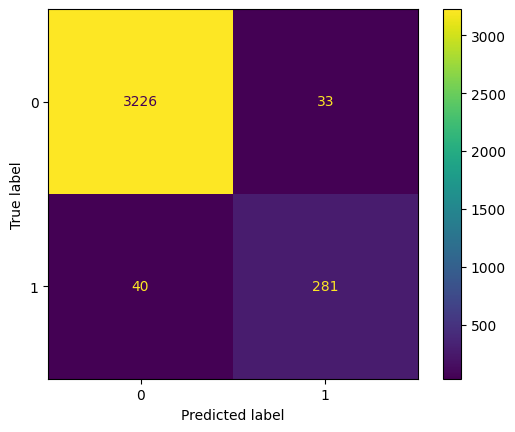

In [31]:
# Plot the confusion matrix with the optimal threshold value for the F1 score (0.45)
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
disp.plot()

In [32]:
# Prints the metrics for the test set
print(f'F1-score: {round(f1_score(y_test, y_pred), 4)}')
print(f'Accuracy: {round(accuracy_score(y_test, y_pred), 4)}')
print(f'Precision: {round(precision_score(y_test, y_pred), 4)}')
print(f'Recall: {round(recall_score(y_test, y_pred), 4)}')
print(f'AUC: {round(roc_auc_score(y_test, y_pred_scores), 4)}')
print(f'Average Precision: {round(average_precision_score(y_test, y_pred_scores), 4)}')

F1-score: 0.885
Accuracy: 0.9796
Precision: 0.8949
Recall: 0.8754
AUC: 0.977
Average Precision: 0.9301


In [33]:
# Calculate the SHAP values
explainer_raw = shap.TreeExplainer(best_model_raw)
shap_values_raw = explainer_raw.shap_values(df.drop(columns='target'))

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


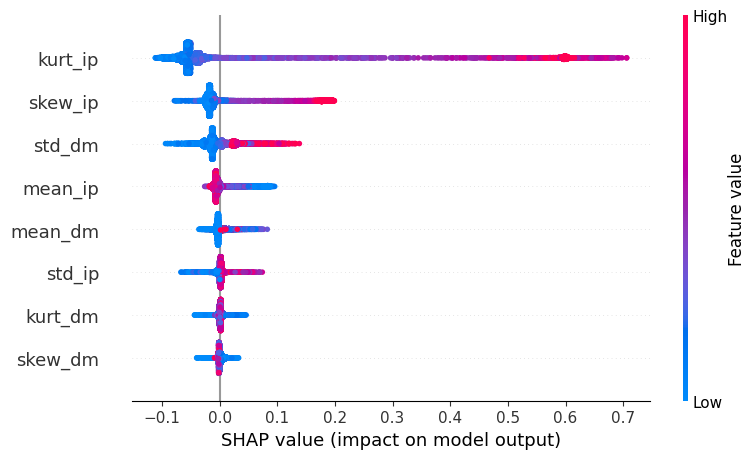

In [42]:
shap.summary_plot(shap_values_raw[1], df.drop(columns='target'))

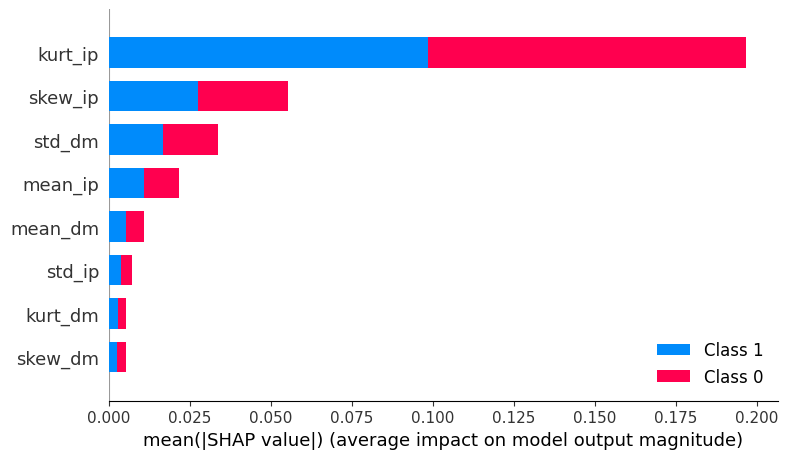

In [44]:
shap.summary_plot(shap_values_raw, df.drop(columns='target'))

- The exact same top 4 important features is found here when comparing to the baseline model, the main difference is that the importance magnitude is a bit different between both. In the tuned model, the kurtosis in ip became even more important, while the others in the top 4 got less importance. The shape and distribution of shap values in the features became the same also, as the best model in this trial did not use weights in the observations to counter the imbalance.

---
## Fourth Tuning - Adjusting Hyperparameters range 

- After analysing the best hyperparameters in each tune, we can see that the n_estimators was always 500, so we will include options with even more estimators.

- The min_samples_leaf was 11 in two and 41 in one, so we will adjust the range for more options in between those values.

- max_features was either 3 or 4, so we will limit the exploration on this variable.

- We will allow the class_weight to be balanced or none.

- The ccp_alpha was always 0, so we will decrease the magnitude of the possible values.

- The objective will be to maximize Average precision

In [49]:
# Create the parameter grid for the random forest model
n_estimators = optuna.distributions.IntDistribution(low=450, high=1050, step=150) # 5 values
min_samples_leaf = optuna.distributions.IntDistribution(low=1, high=31, step=5) # 7 values
ccp_alpha = optuna.distributions.FloatDistribution(low=0, high=0.001, step=0.0005) # 3 values
max_features = optuna.distributions.IntDistribution(low=3, high=5, step=1) # 3 values
class_weight = optuna.distributions.CategoricalDistribution(choices=['balanced', None]) # 2 values

param_grid_dhypm = { 
    'rf__n_estimators': n_estimators,
    'rf__min_samples_leaf': min_samples_leaf,
    'rf__ccp_alpha': ccp_alpha,
    'rf__max_features': max_features,
    'rf__class_weight': class_weight   
}

In [51]:
# Tune the hyperparameters
optuna_search_obj_auprc_dhypm = tune_hyperparams(
    model=model_pipe,
    X_train=X_train,
    y_train=y_train,
    param_grid=param_grid_dhypm,
    scoring_metric='average_precision',
    cv=3,
    n_trials=150,
    random_state=42,
    n_jobs=-1,
    optuna_obj_filename='optuna_search_obj_auprc_dhypm.pkl',
    trials_scores_filename='trials_scores_auprc_dhypm.csv',
)

OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.


Initialized the hyperparameter search with the following attributes:

OptunaSearchCV(cv=3,
               estimator=Pipeline(steps=[('outlier_flagger_ip',
                                          OutlierFlagger(columns=Index(['mean_ip', 'std_ip', 'kurt_ip', 'skew_ip'], dtype='object'),
                                                         outlier_col_name='ip_outlier')),
                                         ('outlier_flagger_dm',
                                          OutlierFlagger(columns=Index(['mean_dm', 'std_dm', 'kurt_dm', 'skew_dm'], dtype='object'),
                                                         outlier_col_name='dm_outlier')),
                                         ('robust_scaling',
                                          Robust...
               param_distributions={'rf__ccp_alpha': FloatDistribution(high=0.001, log=False, low=0.0, step=0.0005),
                                    'rf__class_weight': CategoricalDistribution(choices=('balanced', None)

[I 2023-09-05 03:12:26,893] A new study created in memory with name: no-name-efcc6c64-4082-485a-bc5f-5778e0fd25c4
[I 2023-09-05 03:17:46,241] Trial 0 finished with value: 0.9219908210440418 and parameters: {'rf__n_estimators': 600, 'rf__min_samples_leaf': 31, 'rf__ccp_alpha': 0.001, 'rf__max_features': 3, 'rf__class_weight': 'balanced'}. Best is trial 0 with value: 0.9219908210440418.
[I 2023-09-05 03:19:01,906] Trial 5 finished with value: 0.9270167026406307 and parameters: {'rf__n_estimators': 600, 'rf__min_samples_leaf': 6, 'rf__ccp_alpha': 0.0, 'rf__max_features': 3, 'rf__class_weight': None}. Best is trial 5 with value: 0.9270167026406307.
[I 2023-09-05 03:21:28,331] Trial 6 finished with value: 0.9223005020219541 and parameters: {'rf__n_estimators': 900, 'rf__min_samples_leaf': 21, 'rf__ccp_alpha': 0.0005, 'rf__max_features': 3, 'rf__class_weight': 'balanced'}. Best is trial 5 with value: 0.9270167026406307.
[I 2023-09-05 03:22:24,061] Trial 4 finished with value: 0.9141922937566

Best hyperparameters: {'rf__n_estimators': 900, 'rf__min_samples_leaf': 11, 'rf__ccp_alpha': 0.0, 'rf__max_features': 5, 'rf__class_weight': None}
Best average_precision score: 0.9274054809811708
Saving the trials scores to a csv file...

Saving the optuna search object to a pickle file...



In [52]:
# train the best model
best_model_auprc_dhypm, cv_scores_dhypm = cv_train_best_model(
    optuna_search_obj=optuna_search_obj_auprc_dhypm,
    model=model_pipe,
    X_train=X_train,
    y_train=y_train,
    model_file_name='rf_feat_preproc_tuned_auprc_dhypm.pkl',
    cv_scores_file_name='rf_feat_preproc_tuned_auprc_dhypm_cv_scores.csv',
    kfolds=3
)


Instantiating the data and model...

Starting the cross validation loops with different thresholds...

Cross-validating with threshold = 0.1...

Cross-validating with threshold = 0.15000000000000002...

Cross-validating with threshold = 0.20000000000000004...

Cross-validating with threshold = 0.25000000000000006...

Cross-validating with threshold = 0.30000000000000004...

Cross-validating with threshold = 0.3500000000000001...

Cross-validating with threshold = 0.40000000000000013...

Cross-validating with threshold = 0.45000000000000007...

Cross-validating with threshold = 0.5000000000000001...

Cross-validating with threshold = 0.5500000000000002...

Cross-validating with threshold = 0.6000000000000002...

Cross-validating with threshold = 0.6500000000000001...

Cross-validating with threshold = 0.7000000000000002...

Cross-validating with threshold = 0.7500000000000002...

Cross-validating with threshold = 0.8000000000000002...

Cross-validating with threshold = 0.850000000000000

In [53]:
best_model_auprc_dhypm.get_params()['rf'].get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 5,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 11,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 900,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [54]:
cv_scores_grouped = cv_scores_dhypm.groupby('threshold').mean()
cv_scores_grouped

,fit_time,score_time,test_F1-score,test_Accuracy,test_Precision,test_Recall,test_AUC,test_Average Precision
threshold,,,,,,,,
0.10,147.428687,1.401932,0.817850,0.962495,0.740001,0.914266,0.976762,0.927405
0.15,147.399562,1.349297,0.848213,0.970177,0.798011,0.905158,0.976762,0.927405
0.20,150.133287,1.368057,0.858394,0.972901,0.827812,0.891503,0.976762,0.927405
0.25,149.429967,1.392657,0.868190,0.975346,0.855243,0.881639,0.976762,0.927405
0.30,149.073818,1.429606,0.873384,0.976603,0.870537,0.876325,0.976762,0.927405
0.35,149.174061,1.344848,0.880879,0.978349,0.892637,0.869495,0.976762,0.927405
0.40,146.842550,1.336287,0.883592,0.979117,0.907337,0.861144,0.976762,0.927405
0.45,147.034248,1.337613,0.880763,0.978838,0.915055,0.849009,0.976762,0.927405
0.50,148.366761,1.346715,0.877392,0.978489,0.923003,0.836119,0.976762,0.927405


In [55]:
# Calculate the predicted probabilities and the predicted classes for the optimal threshold
opt_threshold = cv_scores_grouped['test_F1-score'].idxmax()
y_pred_scores = best_model_auprc_dhypm.predict_proba(X_test)[:, 1]
y_pred = (y_pred_scores > opt_threshold).astype(int)

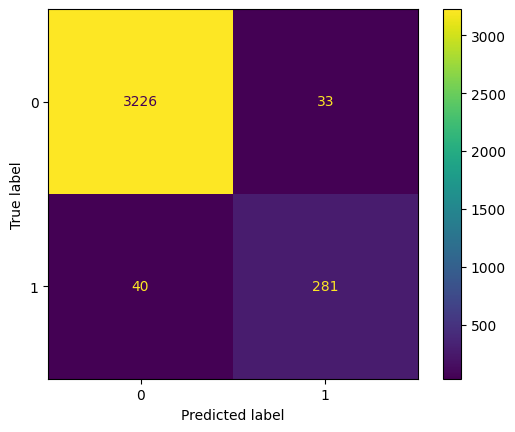

In [56]:
# Plot the confusion matrix with the optimal threshold value for the F1 score (0.45)
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
disp.plot()

In [57]:
# Prints the metrics for the test set
print(f'F1-score: {round(f1_score(y_test, y_pred), 4)}')
print(f'Accuracy: {round(accuracy_score(y_test, y_pred), 4)}')
print(f'Precision: {round(precision_score(y_test, y_pred), 4)}')
print(f'Recall: {round(recall_score(y_test, y_pred), 4)}')
print(f'AUC: {round(roc_auc_score(y_test, y_pred_scores), 4)}')
print(f'Average Precision: {round(average_precision_score(y_test, y_pred_scores), 4)}')

F1-score: 0.885
Accuracy: 0.9796
Precision: 0.8949
Recall: 0.8754
AUC: 0.9759
Average Precision: 0.9319


In [58]:
# Calculate the SHAP values
shap.initjs()
pipe_feats_dhypm = Pipeline(best_model_auprc_dhypm.steps[:-1])
X_transformed = pipe_feats_dhypm.transform(df.drop(columns='target'))

explainer_dhypm = shap.TreeExplainer(best_model_auprc_dhypm.named_steps['rf'])
shap_values_dhypm = explainer_dhypm.shap_values(X_transformed)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


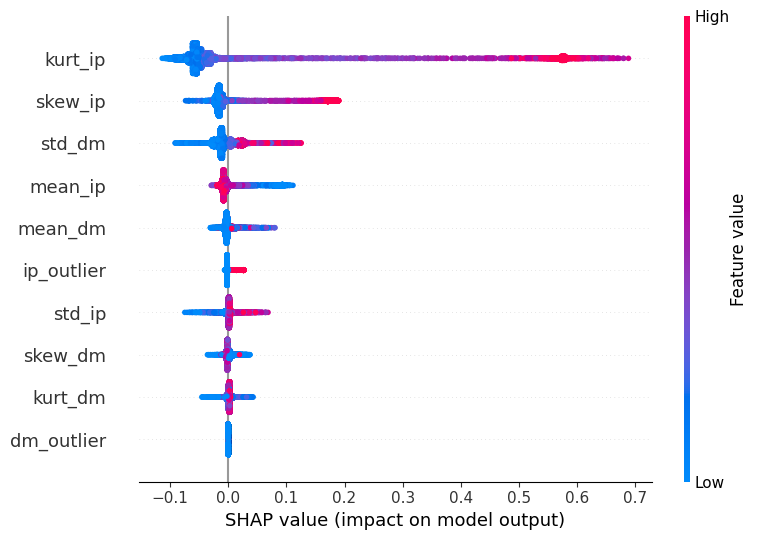

In [59]:
shap.summary_plot(shap_values_dhypm[1], X_transformed)

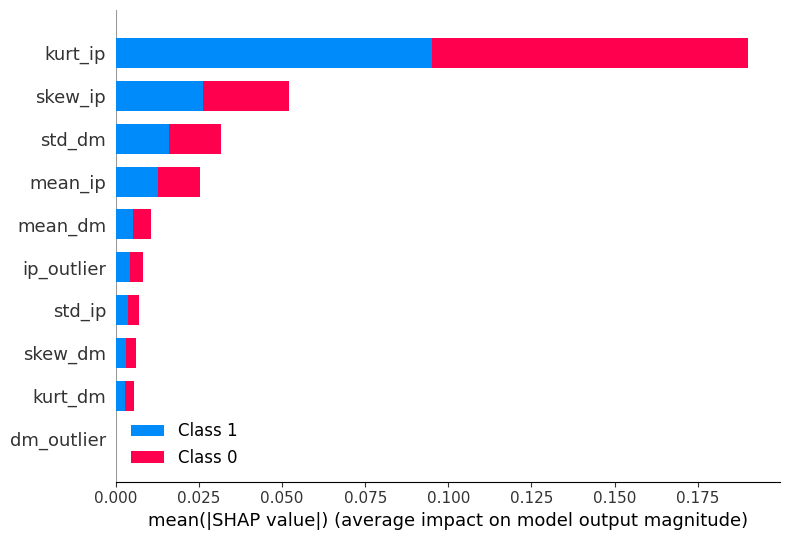

In [60]:
shap.summary_plot(shap_values_dhypm, X_transformed)